In [1]:
from elpv.utils.elpv_reader import load_dataset
import numpy as np

from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

import cv2 as cv
# from PIL import Image
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'elpv'

In [ ]:
images, probs, types = load_dataset()
images = images.astype("float32") / 255

In [3]:
mono_images = images[types == "mono"]
mono_probs = probs[types == "mono"]

poly_images = images[types == "poly"]
poly_probs = probs[types == "poly"]

#### Identify Probabilities for All Cells (Original Paper)

In [4]:
# types_label_encoder = LabelEncoder()
# types = types_label_encoder.fit_transform(types)
# types = keras.utils.to_categorical(types)

probs_oh = probs
probs_label_encoder = LabelEncoder()
probs_oh = probs_label_encoder.fit_transform(probs_oh)
probs_oh = keras.utils.to_categorical(probs_oh)

images_3 = np.dstack([images] * 3)
images_3 = np.reshape(images_3, (-1, 300, 300, 3))

In [1]:
for i in np.unique(probs):
    print(i)

NameError: name 'np' is not defined

In [113]:
X_train, X_test, y_train, y_test = train_test_split(images_3, probs_oh, test_size=0.25, random_state=50)

In [6]:
vgg19_base = keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(300,300,3))
vgg19_base.trainable = False

# https://github.com/DaveRichmond-/grayscale-imagenet/blob/master/eval_image_classifier_gray.py

vgg19_model = keras.models.Sequential([
  vgg19_base,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Flatten(input_shape=vgg19_base.output_shape[1:]),
  keras.layers.Dense(4096, activation='relu', kernel_initializer='he_normal'),
  keras.layers.Dense(2048, activation='relu', kernel_initializer='he_normal'),
  keras.layers.Dense(len(np.unique(probs)), activation='softmax')
])

: 

In [17]:
vgg19_model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3)

history = vgg19_model.fit(X_train, y_train, epochs=100, validation_split = 0.2, callbacks=[es], batch_size=16)

Epoch 1/100
 9/99 [=>............................] - ETA: 1:43 - loss: 7.7057 - accuracy: 0.3958

KeyboardInterrupt: 

#### Classify Solar Panels by Type

In [ ]:
label_encoder = LabelEncoder()
types = label_encoder.fit_transform(types)
types = keras.utils.to_categorical(types)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, types, test_size=0.25, random_state=50)

In [ ]:
type_model = keras.models.Sequential()
type_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)))
type_model.add(keras.layers.MaxPooling2D((2, 2)))
type_model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
type_model.add(keras.layers.MaxPooling2D((2, 2)))
type_model.add(keras.layers.Flatten())
type_model.add(keras.layers.Dense(64, activation='relu'))
type_model.add(keras.layers.Dense(2, activation = "softmax"))

In [ ]:
type_model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = type_model.fit(X_train, y_train, epochs=10, validation_split = 0.2)

Epoch 1/10
50/50 [==============================] - 92s 2s/step - loss: 1.6111 - accuracy: 0.5680 - val_loss: 0.5895 - val_accuracy: 0.5812
Epoch 2/10
50/50 [==============================] - 97s 2s/step - loss: 0.5308 - accuracy: 0.7795 - val_loss: 0.3541 - val_accuracy: 0.8528
Epoch 3/10
50/50 [==============================] - 89s 2s/step - loss: 0.2134 - accuracy: 0.9231 - val_loss: 0.1103 - val_accuracy: 0.9949
Epoch 4/10
50/50 [==============================] - 94s 2s/step - loss: 0.0817 - accuracy: 0.9752 - val_loss: 0.0718 - val_accuracy: 0.9746
Epoch 5/10
50/50 [==============================] - 96s 2s/step - loss: 0.0501 - accuracy: 0.9835 - val_loss: 0.0498 - val_accuracy: 0.9898
Epoch 6/10
50/50 [==============================] - 88s 2s/step - loss: 0.0308 - accuracy: 0.9905 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 7/10
50/50 [==============================] - 85s 2s/step - loss: 0.0113 - accuracy: 0.9987 - val_loss: 0.0104 - val_accuracy: 0.9975
Epoch 8/10
50/50 [==

In [ ]:
PATH = 'models/2_layer_type.keras'
type_model.save(PATH)

In [ ]:
score = type_model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.017227618023753166
Test accuracy: 0.9969512224197388


#### Identify Probabilities for Mono Solar Cells

In [ ]:
mono_images_3 = []
for image in mono_images:
    mono_images_3.append(cv.cvtColor(image, cv.COLOR_GRAY2RGB))
mono_images_3 = np.array(mono_images_3)

In [ ]:
mono_images_3.shape

(1074, 300, 300, 3)

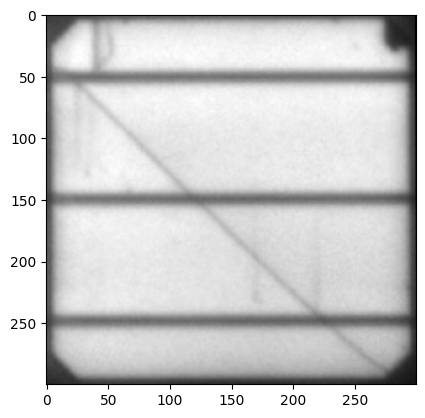

In [ ]:
plt.imshow(images[1], cmap="gray")

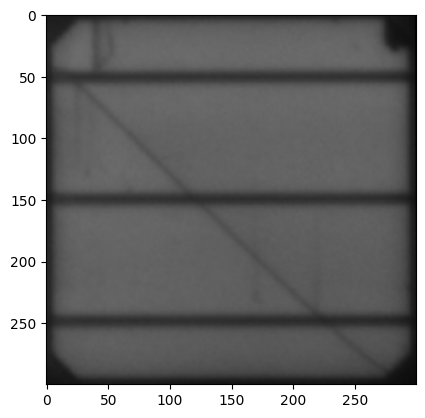

In [ ]:
plt.imshow(mono_images_3[1], cmap="gray")

In [ ]:
label_encoder = LabelEncoder()
mono_probs = label_encoder.fit_transform(mono_probs)
mono_probs = keras.utils.to_categorical(mono_probs)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(mono_images_3, mono_probs, test_size=0.25, random_state=50)

In [ ]:
vgg19_base = keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(300,300,3))
vgg19_base.trainable = False

# https://github.com/DaveRichmond-/grayscale-imagenet/blob/master/eval_image_classifier_gray.py

vgg19_mono_model = keras.models.Sequential([
  vgg19_base,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Flatten(input_shape=vgg19_base.output_shape[1:]),
  keras.layers.Dense(4096, activation='relu', kernel_initializer='he_normal'),
  keras.layers.Dense(2048, activation='relu', kernel_initializer='he_normal'),
  keras.layers.Dense(len(np.unique(probs)), activation='softmax')
])

In [ ]:
vgg19_mono_model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3)

history = vgg19_mono_model.fit(X_train, y_train, epochs=100, validation_split = 0.2, callbacks=[es], batch_size=16)

Epoch 1/100
41/41 [==============================] - 270s 6s/step - loss: 2.5978 - accuracy: 0.4643 - val_loss: 1.1020 - val_accuracy: 0.4534
Epoch 2/100
41/41 [==============================] - 357s 9s/step - loss: 1.0816 - accuracy: 0.5606 - val_loss: 1.0681 - val_accuracy: 0.5528
Epoch 3/100
41/41 [==============================] - 268s 7s/step - loss: 0.9480 - accuracy: 0.6568 - val_loss: 0.9438 - val_accuracy: 0.6584
Epoch 4/100
41/41 [==============================] - 325s 8s/step - loss: 0.9298 - accuracy: 0.6661 - val_loss: 0.9933 - val_accuracy: 0.6646
Epoch 5/100
41/41 [==============================] - 392s 10s/step - loss: 0.8525 - accuracy: 0.7096 - val_loss: 0.9590 - val_accuracy: 0.6894
Epoch 6/100
41/41 [==============================] - 355s 9s/step - loss: 0.8597 - accuracy: 0.7019 - val_loss: 0.8949 - val_accuracy: 0.6894
Epoch 7/100
41/41 [==============================] - 344s 8s/step - loss: 0.8205 - accuracy: 0.7065 - val_loss: 0.9523 - val_accuracy: 0.6708
Epoch

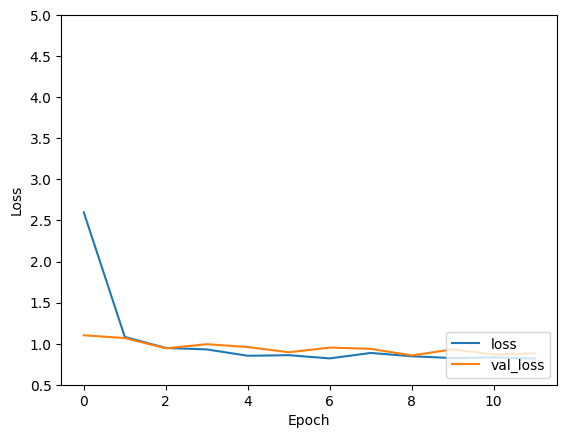

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.5, 5])
plt.legend(loc='lower right')